# Cell Migration RTM Pipeline
This notebook showcases an example how to do directed migration as shown in the real-time feedback microscopy paper. The frontal part of the cells are stimulated using a DMD. The Demo is adapted to run on our Ti2 microscope called Niesen (see our [Mic config repository](https://github.com/pertzlab/pertzlab_mic_configs) for the full configuration file). 

### Import required libraries

In [2]:
import os
import time

os.environ["QT_LOGGING_RULES"] = (
    "*.debug=false; *.warning=false"  # Fix to suppress PyQT warnings from napari-micromanager when running in a Jupyter notebook
)
os.environ["MICROMANAGER_PATH"] = "C:\\Program Files\\Micro-Manager-2.0"

from rtm_pymmcore.data_structures import Fov, Channel, StimTreatment
from pprint import pprint
import pandas as pd
import numpy as np
import dataclasses
import random
import pymmcore_plus

mmc = pymmcore_plus.CMMCorePlus()

### Experimental Settings

In [7]:
%load_ext autoreload
%autoreload 2

## Configuration options
TIME_BETWEEN_TIMESTEPS = 20  # time in seconds between frames

N_FRAMES = 60 // TIME_BETWEEN_TIMESTEPS * 20

FIRST_FRAME_STIMULATION = 0

SLEEP_BEFORE_EXPERIMENT_START_in_H = 0
USE_AUTOFOCUS_EVENT = False

TIME_PER_FOV = 20  # time in seconds per fov


## Storage path for the experiment
base_path = "C:\\Users\\Alex\\Ausbildung\\PhD_temp\\test_exp"
experiment_name = "exp_test_02"
path = os.path.join(base_path, experiment_name)


# Define Channels for which Images are taken. If no power is defined, the default power of the device will be used,
# for example, see the second channel "Cy5" below. The default power is set in the GUI
channels = []
channels.append(Channel(name="Green", exposure=100))


# Condition mapping to FOVs. This is used to create a dataframe with the conditions and the FOVs.
condition = [
    "mCherry",
]  # Example of adding a condition to the dataframe. Stimulation will be repeated for each condition.
# condition = ["optoFGFR_high"] * 24 + ["optoFGFR"] * 24 # Example of adding multiple conditions to the dataframe. n repreats the amount of times the condition is repeated.

n_fovs_per_condition = None  ## change this variable to the amount of fovs that you have per cell line. If only one cell line is set, this value will
# automatically set to total amount of fovs.

n_fovs_per_well = None  ## change this variable to the amount of fovs that you have per well. Set to None if you are not working with wellplate.


# Stimulation parameters for optogenetics. The stimulation will be repeated for each condition.

stim_exposures = [
    100
]  # or e.g. [10, 20, 30] for different exposures. The exposure time is the time that the LED is on.
# Define the stimulation timesteps
stim_timesteps = [
    range(FIRST_FRAME_STIMULATION, N_FRAMES, 1)
]  # Using range to define timesteps from FIRST_FRAME_STIMULATION to N_FRAMES with step 2

# Combine the different paramters in stim_exposure and stim timestep to create stim_treatments which represents all possible combinations
stim_treatments = [
    StimTreatment(
        stim_channel_name="CyanStim",
        stim_channel_group="WF_DMD",
        stim_timestep=stim_timestep,
        stim_exposure=stim_exposure,
        stim_power=10,
        stim_channel_device_name="LedDMD",
        stim_channel_power_property_name="Cyan_Level",
    )
    for stim_exposure in stim_exposures
    for stim_timestep in stim_timesteps
]
for stim_treatment in stim_treatments:
    if isinstance(stim_treatment.stim_timestep, range):
        stim_treatment.stim_timestep = tuple(stim_treatment.stim_timestep)

## Define the Tools that you are using for the experiment
from rtm_pymmcore.segmentation.cellpose import SegmentorCellpose
from rtm_pymmcore.stimulation.percentage_of_cell import StimPercentageOfCell
from rtm_pymmcore.tracking.trackpy import TrackerTrackpy
from rtm_pymmcore.feature_extraction.simple_fe import SimpleFE

segmentators = [
    {
        "name": "labels",
        "class": SegmentorCellpose(model="cyto3", diameter=75, flow_threshold=0.4),
        "use_channel": 0,
        "save_tracked": True,
    },
]

stimulator = StimPercentageOfCell()
feature_extractor = SimpleFE("labels")
tracker = TrackerTrackpy()

pprint(stim_treatments, depth=2)


from rtm_pymmcore.img_processing_pip import ImageProcessingPipeline

pipeline = ImageProcessingPipeline(
    storage_path=path,
    segmentators=segmentators,
    feature_extractor=feature_extractor,
    tracker=tracker,
    stimulator=stimulator,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[StimTreatment(stim_channel_name='CyanStim',
               stim_channel_group='WF_DMD',
               stim_timestep=(...),
               stim_exposure=100,
               stim_power=10,
               stim_channel_device_name='LedDMD',
               stim_channel_power_property_name='Cyan_Level')]
Directory C:\Users\Alex\Ausbildung\PhD_temp\test_exp\exp_test_02\raw already exists
Directory C:\Users\Alex\Ausbildung\PhD_temp\test_exp\exp_test_02\tracks already exists
Directory C:\Users\Alex\Ausbildung\PhD_temp\test_exp\exp_test_02\stim_mask already exists
Directory C:\Users\Alex\Ausbildung\PhD_temp\test_exp\exp_test_02\stim already exists
Directory C:\Users\Alex\Ausbildung\PhD_temp\test_exp\exp_test_02\particles already exists
Directory C:\Users\Alex\Ausbildung\PhD_temp\test_exp\exp_test_02\labels already exists


#### Test functions to directly see results from experiment before the start of it

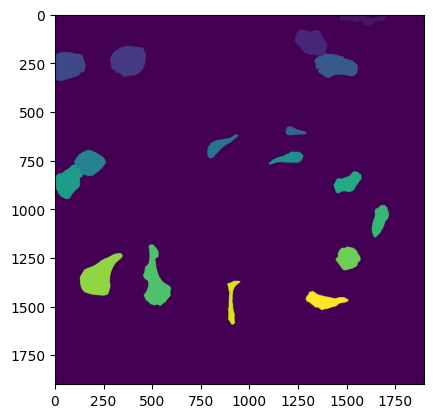

In [12]:
import tifffile

seg = SegmentorCellpose(model="cyto3", diameter=75, flow_threshold=0.4)
raw = tifffile.imread(
    os.path.join(path_with_old_data_for_simulation, "raw", "000_00000.tiff")
)
res = seg.segment(raw)
import matplotlib.pyplot as plt

plt.imshow(res)

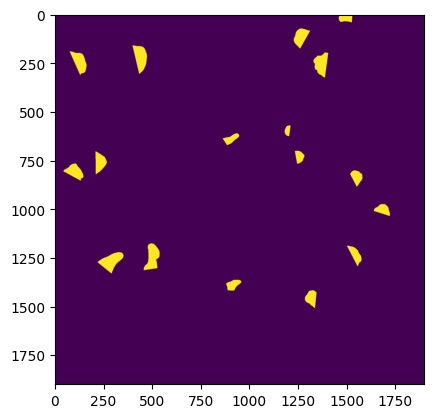

In [24]:
stim_mask = stimulator.get_stim_mask({"labels": res}, {})
plt.imshow(stim_mask[0])

### Load device and set startup channel

In [ ]:
mmc.loadSystemConfiguration(
    "E:\\pertzlab_mic_configs\\micromanager\\Niesen\\Ti2CicercoConfig_w_DMD_w_TTL.cfg"
)
mmc.setConfig(groupName="System", configName="Startup")

### The following libraries are used to wake up the Lumencor laser
import requests
import threading
import time
from useq._mda_event import SLMImage
from useq import MDAEvent


class WakeUpLaser:
    def __init__(self, lumencore_ip="192.168.201.200"):
        self.ip = lumencore_ip
        self.last_wakeup = 0
        self.is_running = False

    def wakeup_laser(self):
        url = f"http://{self.ip}/service/?command=WAKEUP"
        requests.get(url)

    def run(self, wait_for_warmup=False):
        self.is_running = True
        self.thread = threading.Thread(target=self._keep_alive)
        self.thread.start()
        if wait_for_warmup:
            time.sleep(15)

    def _keep_alive(self):
        while self.is_running:
            if time.time() - self.last_wakeup > 60:
                self.wakeup_laser()
                self.last_wakeup = time.time()
            time.sleep(3)

    def stop(self):
        self.is_running = False
        self.thread.join()


wl = WakeUpLaser()
wl.wakeup_laser()

slm_dev = mmc.getSLMDevice()
slm_width = mmc.getSLMWidth(slm_dev)
slm_height = mmc.getSLMHeight(slm_dev)

event_slm_on = MDAEvent(slm_image=SLMImage(data=True))
mmc.mda.run([event_slm_on])  # to only have fov of DMD
mmc.setROI(150, 150, 1900, 1900)

DMD_CHANNEL_GROUP = "WF_DMD"
DMD_CALIBRATION_PROFILE = {
    "channel_group": "WF_DMD",
    "channel_config": "CyanStim",
    "device_name": "LedDMD",
    "property_name": "Cyan_Level",
    "power": 100,
}
mmc.setChannelGroup(channelGroup=DMD_CHANNEL_GROUP)

### GUI - Napari Micromanager

#### Load GUI

In [ ]:
### Base GUI ###
from napari_micromanager import MainWindow
import napari

viewer = napari.Viewer()
mm_wdg = MainWindow(viewer)
viewer.window.add_dock_widget(mm_wdg)
data_mda_fovs = None

### Add MDA widget for FOV selection ###
from pymmcore_widgets.mda import MDAWidget

mdawidget = MDAWidget(mmcore=mmc)
viewer.window.add_dock_widget(mdawidget)
load_from_file = False

#### Functions to break and re-connect link with GUI if manually broken

The following functions can be used to manually interrupt to connection between the GUI and the running rtm-pymmcore script. However, normally you don't need to execute them. 

In [ ]:
### Break connection
# mm_wdg._core_link.cleanup()

In [ ]:
### Manually reconnect pymmcore with napari-micromanager
from napari_micromanager._core_link import CoreViewerLink

mm_wdg._core_link = CoreViewerLink(viewer, mmc)

### Map Experiment to FOVs

#### If FOVs already saved - Reload them from file

In [ ]:
import json

file = os.path.join(path, "fovs.json")
with open(file, "r") as f:
    data_mda_fovs = json.load(f)
load_from_file = True

### Use FOVs to generate dataframe for acquisition

In [ ]:
n_fovs_simultaneously = TIME_BETWEEN_TIMESTEPS // TIME_PER_FOV
timesteps = range(N_FRAMES)

start_time = 0
if not load_from_file:
    data_mda_fovs = mdawidget.value().stage_positions
    data_mda_fovs_dict = []
    for data_mda in data_mda_fovs:
        data_mda_fovs_dict.append(data_mda.model_dump())
    data_mda_fovs = data_mda_fovs_dict
    if data_mda_fovs is None:
        assert False, "No fovs selected. Please select fovs in the MDA widget"

dfs = []
fovs = []
for fov_index, fov in enumerate(data_mda_fovs):
    fov_object = Fov(fov_index)
    fovs.append(fov_object)
    fov_group = fov_index // n_fovs_simultaneously
    start_time = fov_group * TIME_BETWEEN_TIMESTEPS * len(timesteps)
    if len(condition) == 1:
        condition_fov = condition[0]
    else:
        condition_fov = condition[fov_index // n_fovs_per_condition]
    for timestep in timesteps:
        row = {
            "fov_object": fov_object,
            "fov": fov_index,
            "fov_x": fov.get("x"),
            "fov_y": fov.get("y"),
            "fov_z": fov.get("z"),
            "fov_name": str(fov_index) if fov["name"] is None else fov.get("name"),
            "timestep": timestep,
            "time": start_time + timestep * TIME_BETWEEN_TIMESTEPS,
            "cell_line": condition_fov,
            "channels": tuple(dataclasses.asdict(channel) for channel in channels),
            "fname": f"{str(fov_index).zfill(3)}_{str(timestep).zfill(5)}",
        }
        dfs.append(row)

df_acquire = pd.DataFrame(dfs)

print(f"Total Experiment Time: {df_acquire['time'].max()/3600}h")

for stim_treatment in stim_treatments:
    if isinstance(stim_treatment.stim_timestep, range):
        stim_treatment.stim_timestep = tuple(stim_treatment.stim_timestep)

n_fovs = len(data_mda_fovs)
n_stim_treatments = len(stim_treatments)
if n_stim_treatments > 0:
    n_fovs_per_stim_condition = n_fovs // n_stim_treatments // len(np.unique(condition))
    stim_treatment_tot = []
    random.shuffle(stim_treatments)
    if n_fovs_per_well is not None:
        for stim_treat in stim_treatments:
            stim_treatment_tot.extend([stim_treat] * n_fovs_per_well)

    else:
        for fov_index in range(0, n_fovs_per_stim_condition):
            stim_treatment_tot.extend(stim_treatments)
        random.shuffle(stim_treatment_tot)

        if n_fovs % n_stim_treatments != 0:
            print(
                f"Warning: Not equal number of fovs per stim condition. {n_fovs % n_stim_treatments} fovs will have repeated treatment"
            )
            stim_treatment_tot.extend(stim_treatments[: n_fovs % n_stim_treatments])
    print(f"Doing {n_fovs_per_stim_condition} experiment per stim condition")

    if len(condition) == 1:
        n_fovs_per_condition = n_fovs
    else:
        stim_treatment_tot = stim_treatment_tot * len(np.unique(condition))

    df_acquire = pd.merge(
        df_acquire, pd.DataFrame(stim_treatment_tot), left_on="fov", right_index=True
    )

    # Add stim column that checks if current timestep is in the stim_timestep tuple
    df_acquire["stim"] = df_acquire.apply(
        lambda row: (
            row["timestep"] in row["stim_timestep"]
            if isinstance(row["stim_timestep"], tuple) and row["stim_exposure"] > 0
            else False
        ),
        axis=1,
    )

df_acquire = df_acquire.dropna(axis=1, how="all")
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", True)
df_acquire = df_acquire.sort_values(by=["time", "fov"]).reset_index(drop=True)
df_acquire

Total Experiment Time: 0.005555555555555556h
Doing 1 experiment per stim condition


,fov_object,fov,fov_x,fov_y,fov_z,fov_name,timestep,time,cell_line,channels,fname,stim_channel_name,stim_channel_group,stim_timestep,stim_exposure,stim_power,stim_channel_device_name,stim_channel_power_property_name,stim
0,<rtm_pymmcore.data_structures.Fov object at 0x...,0,0.0,0.0,0.0,0,0,0,mCherry,"({'name': 'DAPI', 'exposure': 150, 'group': No...",000_00000,FITC,Channel,"(0, 1)",100,3,LED,State,True
1,<rtm_pymmcore.data_structures.Fov object at 0x...,0,0.0,0.0,0.0,0,1,20,mCherry,"({'name': 'DAPI', 'exposure': 150, 'group': No...",000_00001,FITC,Channel,"(0, 1)",100,3,LED,State,True


### Run experiment

In [ ]:
pymmcore_plus.configure_logging(stderr_level="WARNING")

from rtm_pymmcore.dmd import DMD

dmd = DMD(mmc, DMD_CHANNEL_GROUP, DMD_CALIBRATION_PROFILE)

In [ ]:
for _ in range(0, SLEEP_BEFORE_EXPERIMENT_START_in_H * 3600):
    time.sleep(1)
from rtm_pymmcore.controller import Controller, Analyzer
from rtm_pymmcore.dmd import DMD
from queue import Queue

try:
    mm_wdg._core_link.cleanup()
except:
    pass


analyzer = Analyzer(pipeline)
queue = Queue()
controller = Controller(analyzer, mmc, queue, dmd=dmd)
controller.run(df_acquire)

In [ ]:
fovs_i_list = os.listdir(os.path.join(path, "tracks"))
fovs_i_list.sort()
dfs = []
for fov_i in fovs_i_list:
    track_file = os.path.join(path, "tracks", fov_i)
    df = pd.read_parquet(track_file)
    dfs.append(df)
pd.concat(dfs).to_parquet(os.path.join(path, "exp_data.parquet"))